In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = '/content/gdrive/My Drive/Colab Notebooks/group feedback web/cleaned_data/'


pd.set_option('display.max_columns', None)
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !pip install outdated
import outdated
import scipy
import statsmodels.api as sm
# !pip install pingouin

In [ ]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols  #Create a Model from a formula and dataframe.

import warnings
warnings.filterwarnings('ignore')
import pingouin as pg

def annot_stat(star, factors, factor, A, B, y, col='k', ax=None):
    stand = factors.index(factor)
    x1 = stand-0.3+0.2*A
    x2 = stand-0.3+0.2*B
    h = 0.03
    y = y+0.23
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h*0.9, y+h*0.9, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color=col)
    
    return y

def post_hoc(t, labelName,factors):
  
  
  print('---Anova starts ...---')
  sigFactor = []
  anovaResult = pd.DataFrame({'df':[], 'sum_sq':[], 'mean_sq':[], 'F':[], 'PR(>F)':[]})
  for var in factors:
    print('-')
    modelLabel = ' ~C('+labelName+')'
    model = ols(var + modelLabel, t).fit()
    temp = anova_lm(model)
    temp.index = [var, 'Residual']
    anovaResult = anovaResult.append(temp)
    if temp['PR(>F)'][var]<0.05:
      sigFactor.append(var)


# significant column -->Gameswell result
# if you want to change post-hoc algorithm, change here
  gameswell = pd.DataFrame(data = {'factor':[],'A':[],'B':[],'mean(A)':[],'mean(B)':[], 'diff':[], 'se':[], 'T':[],'df':[],'pval':[], 'hedges':[]})
  print('--- Gameswell analysis is processing... ---')
  for factor in sigFactor:
    print('-')
    a = pg.pairwise_gameshowell(data=t, dv=factor,between=labelName).round(3) 
    val = []
    for i in range(0,a.shape[0]):
      val.append(factor)
    a.insert(loc=0, column='factor', value=val)
    gameswell = gameswell.append(a)
    
  sigAnnotation = gameswell[gameswell.pval<0.05][['factor','A','B','diff']]
  sigAnnotation.reset_index(drop = True,inplace = True)

  #return gameswell
  factor = []
  zScore = []
  labels = []

  for i in range(0,t.shape[0]):
    row = t.iloc[i]
    for col in sigFactor:
      factor.append(col)
      zScore.append(row[col])
      labels.append(int(row[labelName]))


  Treshape = pd.DataFrame({'factor':factor,'z-score':zScore,'label':labels})

  #if want to save fig, 
  fig = plt.figure(figsize = (16,6))
  ax = sns.barplot(x = 'factor', y = 'z-score', hue = 'label',data = Treshape)
  for i in range(0,sigAnnotation.shape[0]):
    if i == 0:
      y = 1.4
    elif sigAnnotation.factor[i]!=sigAnnotation.factor[i-1]:
      y = 1.4

    if abs(sigAnnotation['diff'][i])>1:
      mark = '***' 
    
    elif abs(sigAnnotation['diff'][i])>0.5:
      mark = '**' 
    
    elif abs(sigAnnotation['diff'][i])>0.3:
      mark = '*' 
    elif abs(sigAnnotation['diff'][i])<0.300001:
      mark = '.'

    y = annot_stat(mark, factors, sigAnnotation.factor[i], sigAnnotation.A[i], sigAnnotation.B[i], y)
  
  plt.show()
  print('Save fig? if you want to --> type "Y"')

  savefig = input()
  if savefig == 'Y':
    print('type the name of the figure:')
    x = input()
    title = x+'.png'
    fig.savefig(title,dpi=300)

  return anovaResult, gameswell

In [ ]:
data = pd.read_csv(path+'clustered_SDAx.csv')
data.head()

,attention,perfectionism,procrastination,sleep_hygene,depression,anxiety,sleep_physiological,sleep_behavioral,sleep_cognitive,sleep_environment,sleep_stability,sleep_daytime,sleep_substance,sleep_bedtime,perf_f1,perf_f2,perf_f3,perf_f4,lpa_5scales_4class,lpa_5scales_3class,kmeans_4,kmedians_4,ward_3
0,-0.868419,-1.212573,-0.916019,0.077326,-1.041480,-0.983405,1.141982,-0.132277,0.143917,0.017726,0.380745,-0.650516,-0.378596,-0.809518,-2.078566,-0.316324,-0.351766,-0.041094,1,1,3,2,3
1,0.923919,0.215633,1.154114,1.994154,0.584927,1.098698,-1.944912,0.114985,-1.067645,0.766311,-1.110508,-1.086577,-3.823607,-0.809518,0.620211,-0.190391,-0.351766,0.384576,2,2,1,3,0
2,0.326473,1.326459,-0.620286,0.415590,-0.137920,0.265857,0.215914,0.617003,-0.715567,0.392019,-0.864451,0.657665,0.769741,-0.809518,1.182456,1.698608,0.256804,-0.041094,4,3,2,0,0
3,-0.270973,1.908321,-1.729286,1.406219,0.223503,-0.150564,-1.018844,-1.383576,1.355479,0.766311,-1.110508,0.657665,-2.675270,-0.809518,0.620211,2.957940,1.068230,0.384576,3,1,2,0,1
4,-0.270973,0.638805,1.154114,2.992837,0.404215,-0.358774,0.215914,-1.383576,-0.197806,-1.479445,-2.355705,-1.958698,-3.249438,-0.809518,0.732660,0.187409,0.865374,-0.041094,4,2,1,3,0


In [ ]:
data.columns

Index(['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression', 'anxiety', 'sleep_physiological', 'sleep_behavioral',
       'sleep_cognitive', 'sleep_environment', 'sleep_stability',
       'sleep_daytime', 'sleep_substance', 'sleep_bedtime', 'perf_f1',
       'perf_f2', 'perf_f3', 'perf_f4', 'lpa_5scales_4class',
       'lpa_5scales_3class', 'kmeans_4', 'kmedians_4', 'ward_3'],
      dtype='object')

---Anova starts ...---
-
-
-
-
-
-
--- Gameswell analysis is processing... ---
-
-
-
-
-
-


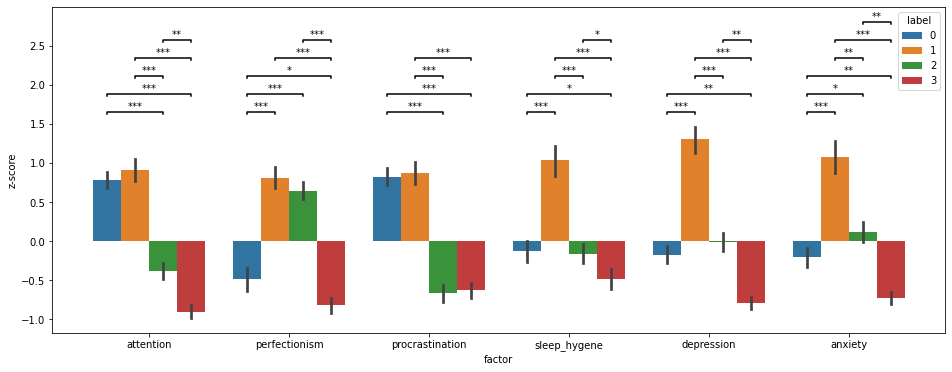

Save fig? if you want to --> type "Y"
Y
type the name of the figure:
whole_gameswell


In [ ]:
labelName = 'kmeans_4'
factors = ['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression', 'anxiety']
anova_whole, gameswell_whole = post_hoc(data, labelName,factors)

---Anova starts ...---
-
-
-
-
-
-
-
-
--- Gameswell analysis is processing... ---
-
-
-
-
-
-


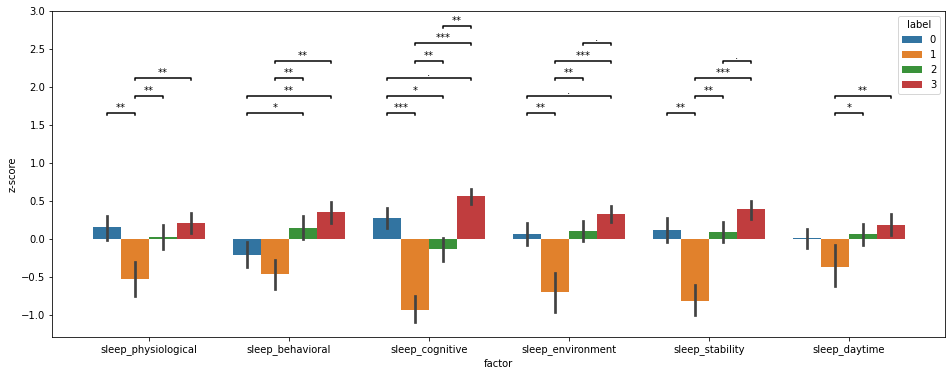

Save fig? if you want to --> type "Y"
Y
type the name of the figure:
sleep_gameswell


In [ ]:
factors = ['sleep_physiological', 'sleep_behavioral',
       'sleep_cognitive', 'sleep_environment', 'sleep_stability',
       'sleep_daytime', 'sleep_substance', 'sleep_bedtime'
       ]
anova_whole, gameswell_whole = post_hoc(data, labelName,factors)

---Anova starts ...---
-
-
-
-
--- Gameswell analysis is processing... ---
-
-
-
-


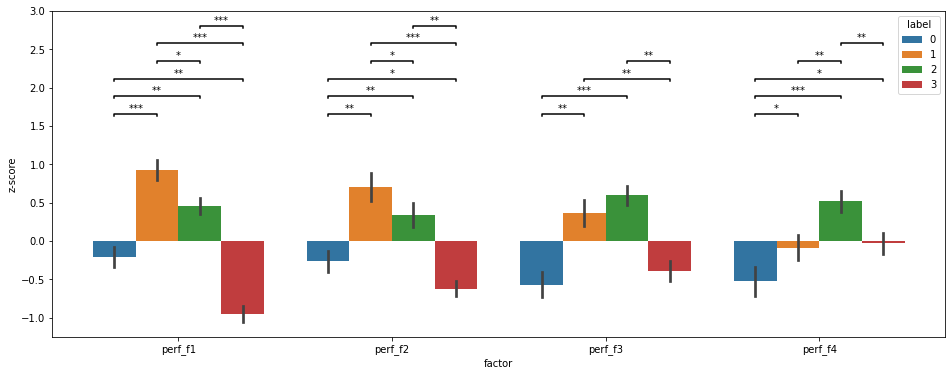

Save fig? if you want to --> type "Y"
Y
type the name of the figure:
perfectionism_gameswell


In [ ]:

factors = ['perf_f1',
       'perf_f2', 'perf_f3', 'perf_f4']
anova_whole, gameswell_whole = post_hoc(data, labelName,factors)

## Each group distribution


In [ ]:
def draw_features(data, col, label):
    x = len(np.unique(label))
    label_1 = min(np.unique(label))
    
    print(x)
    print('silhouette score: ',silhouette_score(data[['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression']],label))
    print('CH score: ',calinski_harabasz_score(data[['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression']],label))
    data_2 = data[['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression']]
    scales = data_2.columns
    
    fig = plt.figure(figsize = (10,7))
    for i in range(0,x):
      
      plt.errorbar(scales,list(data_2[label == label_1].mean()), yerr=list(data_2[label == label_1].std()),fmt='o-', label = str(label_1), capsize=10,elinewidth=3,alpha=0.5)
      label_1 = label_1+1

    plt.xlabel('scales')
    plt.ylabel('z-score')
    plt.legend(loc='best')
    plt.show()

    a = sns.color_palette("YlOrRd", 10)
    weak = a[0]
    
    f, ax = plt.subplots(1,x, figsize = (8*x,7))
    label_1 = min(np.unique(label))
    for i in range(0,x):
      profiles = data[col][label == label_1]
      sns.boxplot(data = profiles,width = 0.7,whis = 1.5, ax = ax[i],color=a[0])
      sns.stripplot(data = profiles,ax = ax[i], size = 3, color = ".3" , linewidth = 0, jitter=0.05)
      ax[i].set_ylim(-3,3)
      mx = profiles.median()
      sns.lineplot(y = mx.values,x=mx.index, linewidth = 2, color= 'orange', ax= ax[i])
      label_1 = label_1+1
    plt.show()

    labels = label.value_counts()
    print(labels)

4
silhouette score:  0.1951364691693386
CH score:  176.55368075368142


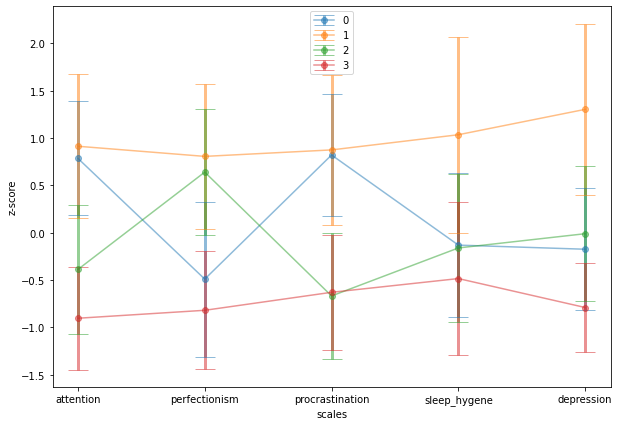

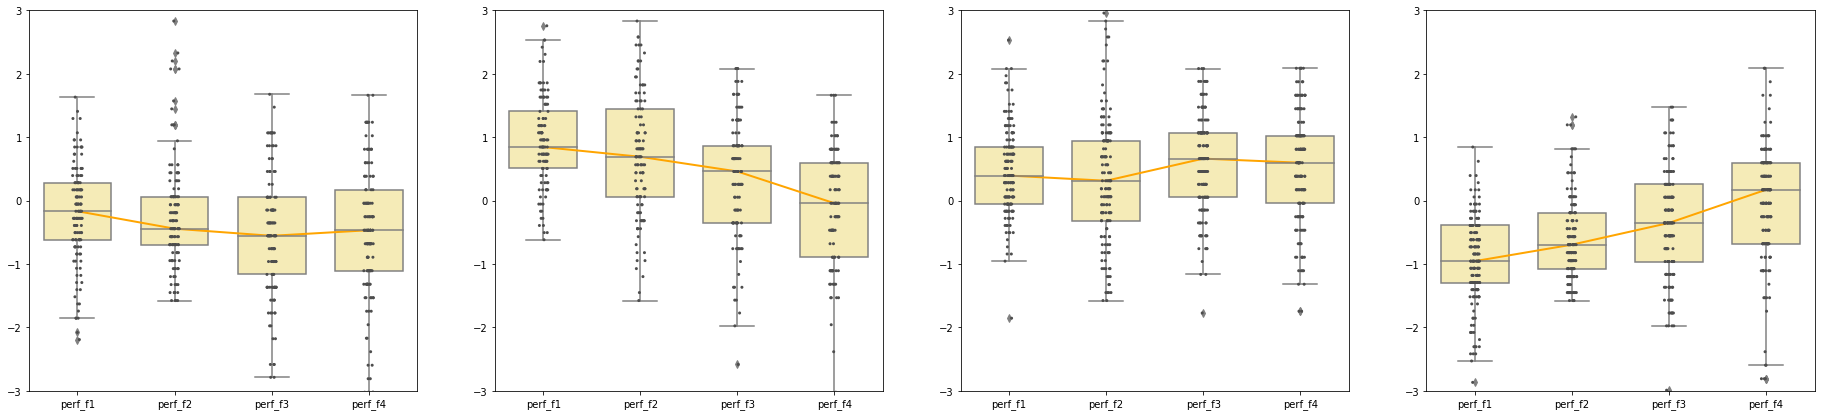

3    157
2    154
0    125
1    113
Name: kmeans_4, dtype: int64


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
draw_features(data, factors, data[labelName])

4
silhouette score:  0.1951364691693386
CH score:  176.55368075368142


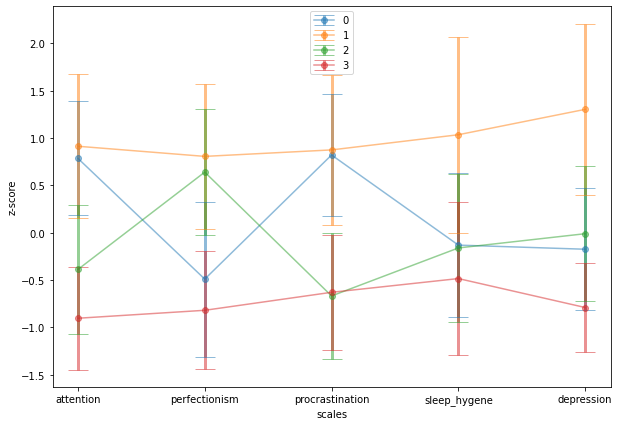

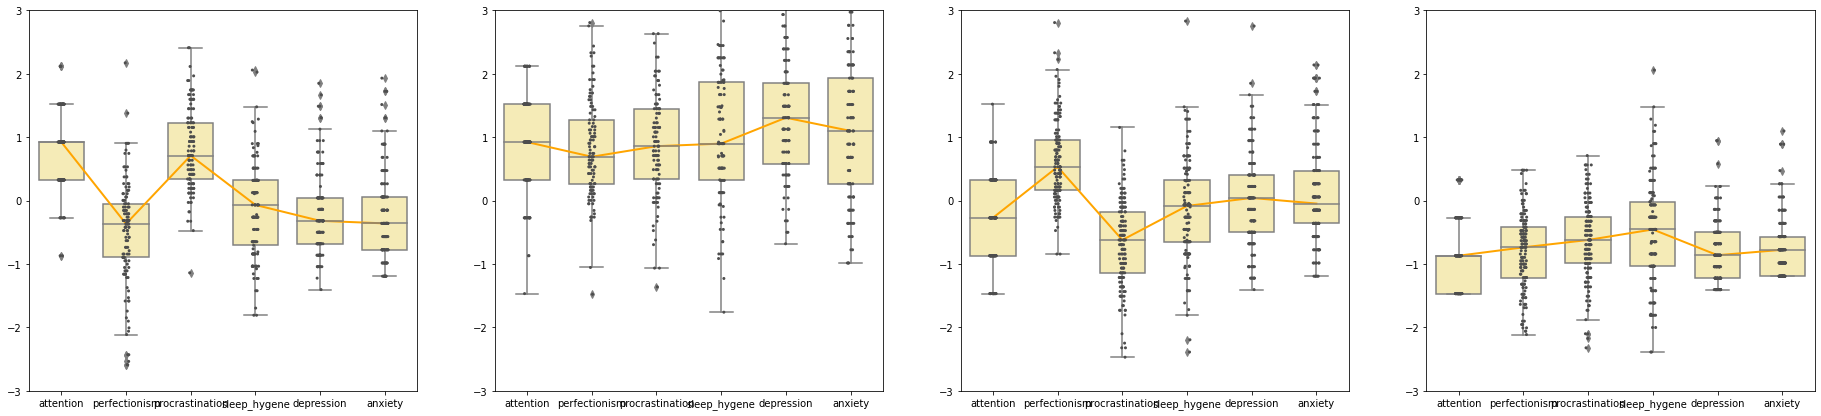

3    157
2    154
0    125
1    113
Name: kmeans_4, dtype: int64


In [21]:
factors = ['attention', 'perfectionism', 'procrastination', 'sleep_hygene',
       'depression', 'anxiety']
draw_features(data, factors, data[labelName])